In [1]:
# ipython hack, as we don't seem to know what __file__ is
mtgencodedir = '/home/mtgencode' # might want to make a symlink

import sys
import os
from collections import OrderedDict
libdir = os.path.join(mtgencodedir, 'lib')
sys.path.append(libdir)
scriptdir = os.path.join(mtgencodedir, 'scripts')
sys.path.append(scriptdir)
datadir = os.path.join(mtgencodedir, 'data')
import jdecode
import ngrams
import analysis

realcards = jdecode.mtg_open_file(str(os.path.join(datadir, 'output.txt')), verbose=True)
separate_lines = True
lm = ngrams.build_ngram_model(realcards, n=3, separate_lines=separate_lines, verbose=True)

mtg_sweep1_dir = '/data/collected/mtg-rnn-sweep1'
char_sweep1_dir = '/data/collected/char-rnn-sweep1'

def sweep_outputs(sweepdir):
    if not os.path.isdir(sweepdir):
        print('not a directory: ' + sweepdir)
        return []
    else:
        return [fname for fname in os.listdir(sweepdir) if os.path.isfile(os.path.join(sweepdir, fname))
                                                           and fname[-4:] == '.txt']

def setup_statistics(sweepdir):
    cps = sweep_outputs(sweepdir)
    all_stats = OrderedDict()
    for cp in cps:
        cp_stats = analysis.get_statistics(os.path.join(sweepdir, cp), lm=lm, sep=separate_lines, verbose=True)
        if 'cp' in cp_stats and 'name' in cp_stats['cp']:
            cp_name = cp_stats['cp']['name']
        else:
            cp_name = cp
        all_stats[cp_name] = cp_stats
    return all_stats

mtg_sweep1 = setup_statistics(mtg_sweep1_dir)
char_sweep1 = setup_statistics(char_sweep1_dir)

print 'Done gathering data.'

Opening encoded card file: /home/mtgencode/data/output.txt
15065 valid, 0 skipped, 0 invalid, 0 failed to parse.
generating 3-gram model
found 25046 sentences
<NgramModel with 34500 3-grams>
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_128_1_epoch50.00_0.3941.output.1.0.txt
5549 valid, 0 skipped, 88 invalid, 29 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_128_2_epoch50.00_0.3862.output.1.0.txt
5360 valid, 0 skipped, 121 invalid, 35 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_256_1_epoch50.00_0.2736.output.1.0.txt
5732 valid, 0 skipped, 71 invalid, 17 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_256_2_epoch50.00_0.2645.output.1.0.txt
5348 valid, 0 skipped, 50 invalid, 29 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_384_2_epoch50.00_0.2102.output.1.0.txt
5887 valid, 0 skipped, 57 invalid, 35 failed to parse.
Ope

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


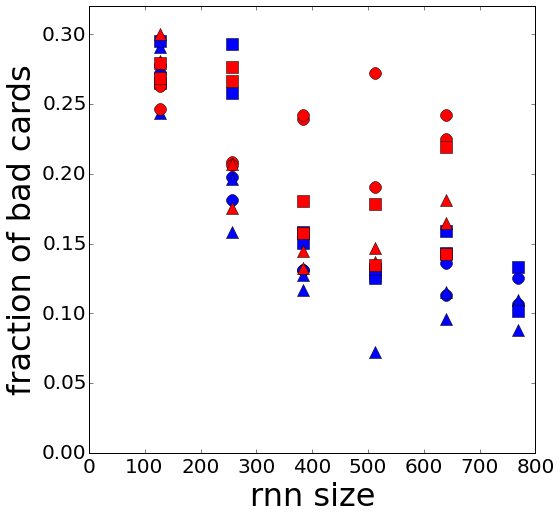

In [43]:
#analysis.print_statistics(mtg_sweep1['baseline_128_1'])
%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
import matplotlib.pyplot as plt
import numpy as np

def size_from_name(cp_name):
    return int(cp_name.split('_')[-2])

def plot_vs_size(getter, yrange, ylabel):

    mtg_sizes_base = [size_from_name(cp) for cp in mtg_sweep1 if 'baseline' in cp]
    char_sizes_base = [size_from_name(cp) for cp in char_sweep1 if 'baseline' in cp]
    mtg_sizes_d25 = [size_from_name(cp) for cp in mtg_sweep1 if 'dropout-25' in cp]
    char_sizes_d25 = [size_from_name(cp) for cp in char_sweep1 if 'dropout-25' in cp]
    mtg_sizes_d50 = [size_from_name(cp) for cp in mtg_sweep1 if 'dropout-50' in cp]
    char_sizes_d50 = [size_from_name(cp) for cp in char_sweep1 if 'dropout-50' in cp]

    mtg_val_base = [getter(mtg_sweep1[cp]) for cp in mtg_sweep1 if 'baseline' in cp]
    char_val_base = [getter(char_sweep1[cp]) for cp in char_sweep1 if 'baseline' in cp]
    mtg_val_d25 = [getter(mtg_sweep1[cp]) for cp in mtg_sweep1 if 'dropout-25' in cp]
    char_val_d25 = [getter(char_sweep1[cp]) for cp in char_sweep1 if 'dropout-25' in cp]
    mtg_val_d50 = [getter(mtg_sweep1[cp]) for cp in mtg_sweep1 if 'dropout-50' in cp]
    char_val_d50 = [getter(char_sweep1[cp]) for cp in char_sweep1 if 'dropout-50' in cp]
    
    plt.plot(mtg_sizes_base, mtg_val_base, 'bo',
             mtg_sizes_d25, mtg_val_d25, 'b^',
             mtg_sizes_d50, mtg_val_d50, 'bs',
             char_sizes_base, char_val_base, 'ro',
             char_sizes_d25, char_val_d25, 'r^',
             char_sizes_d50, char_val_d50, 'rs', markersize=12)
    
    plt.xlabel('rnn size', fontsize=32, color='black')
    plt.ylabel(ylabel, fontsize=32, color='black')
    
    fig = plt.gcf()
    
    ax = fig.gca()
    ax.axis([0,800] + yrange)
    
    fig.set_size_inches(8, 8)
    fig.savefig(ylabel + '.png', dpi=300)
    
    plt.show()

#mtg_vlosses = [mtg_sweep1[cp]['cp']['vloss'] for cp in mtg_sweep1 if 'baseline' in cp]
#char_vlosses = [char_sweep1[cp]['cp']['vloss'] for cp in char_sweep1 if 'baseline' in cp]

#fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(mtg_sizes, mtg_epochs, 'bs', char_sizes, char_epochs, 'g^')
#fig.show()

plot_vs_size(lambda cp: float(cp['props']['overall']['bad']) / cp['props']['overall']['total'], [0, 0.32], 'fraction of bad cards')

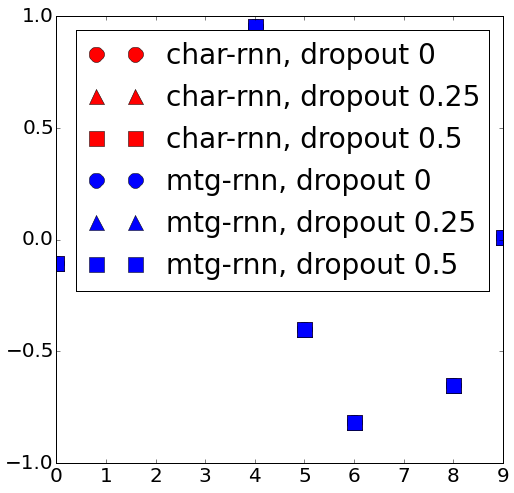

In [48]:
import matplotlib.pyplot as plt
from numpy.random import randn

z = randn(10)

char_base, = plt.plot(z, 'ro', markersize=15)
char_d25, = plt.plot(z, 'r^', markersize=15)
char_d50, = plt.plot(z, 'rs', markersize=15)
mtg_base, = plt.plot(z, 'bo', markersize=15)
mtg_d25, = plt.plot(z, 'b^', markersize=15)
mtg_d50, = plt.plot(z, 'bs', markersize=15)

plt.legend([char_base, char_d25, char_d50, mtg_base, mtg_d25, mtg_d50], ['char-rnn, dropout 0', 'char-rnn, dropout 0.25', 'char-rnn, dropout 0.5', 
                                               'mtg-rnn, dropout 0', 'mtg-rnn, dropout 0.25', 'mtg-rnn, dropout 0.5'], prop={'size':28})

fig = plt.gcf()
fig.set_size_inches(8, 8)
fig.savefig('legend.png', dpi=300)